# Tutorial Step 3: Working with Data Quality

In this tutorial, we will take a look at how data quality information is stored in LIGO data files.
If you are not already comfortable with using Python to read a GWOSC data file, you may want to take a look at [Step 2 of this tutorial](<02 - What's in a GWOSC Data File.ipynb>).

# What's Data Quality?

In addition to the main data output of the LIGO detectors (the "strain" channel), there are hundreds of other data channels that are recorded to monitor the state of both the instruments and the external environment.
Some of these auxillary channels are used to create data quality flags to note times when the strain data is likely to be corrupted by instrumental artifacts.

<div class="alert alert-block alert-warning">
<div><b>&#9888 Warning: Understanding data quality is very important when working with GWOSC data.</b></div>
    Before performing any analysis, use this tutorial and the <a href="https://gwosc.org/data">data documentation</a> to identify the appropriate times for your analysis.
</div>

<div class="alert alert-block alert-warning">
<div><b>&#9888 Warning</b></div>
    Times which fail the DATA category flag are represented by NaNs and should never be analyzed.
    Times which fail any CAT1 level flags have severe problems, and also should not be searched for astrophysical sources. 
</div>

The data quality flags are organized into categories by how severe an impact they may have on a given type of search.
The categories for each type of search are defined differently, but in general, a lower data quality category indicates a more severe problem.
So, for example, a CBC Category 1 flag means that a stretch of data is strongly corrupted and cannot be used to search for low-mass compact binary coalescence (CBC) signals, but a CBC Category 3 flag indicates a less significant problem with the data.

 For a more detailed explanation of the meaning of various flags, see the [data documentation](https://gwosc.org/data).

## How is data quality information stored?

Data quality information is stored in GWOSC data files as a 1 Hz time series for each category.
Notice this is a different sampling rate than the 4096 Hz rate which is used to store strain data.
So, for example, the first sample in a data quality channel applies to the first 4096 samples in the corresponding strain channel.

In the O3b data set, there are 7 data quality categories, as well as 5 injection categories, each represented as a 1 Hz time series.
Let's print out a list of the O3b data quality channel names and descriptions from the data file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

filename = 'H-H1_GWOSC_O3b_4KHZ_R1-1256775680-4096.hdf5'
dataFile = h5py.File(filename, 'r')
gpsStart = dataFile['meta']['GPSstart'][()]

dqInfo = dataFile['quality']['simple']
bitnameList = dqInfo['DQShortnames'][()]
descriptionList = dqInfo['DQDescriptions'][()]
nbits = len(bitnameList)

for bit in range(nbits):
    print(f"Channel #{bit} ({bitnameList[bit].decode()}): {descriptionList[bit].decode()}")

Channel #0 (DATA): data present
Channel #1 (CBC_CAT1): passes the cbc CAT1 test
Channel #2 (CBC_CAT2): passes cbc CAT2 test
Channel #3 (CBC_CAT3): passes cbc CAT3 test
Channel #4 (BURST_CAT1): passes burst CAT1 test
Channel #5 (BURST_CAT2): passes burst CAT2 test
Channel #6 (BURST_CAT3): passes burst CAT3 test


All the data quality categories are combined into a bit mask, and stored as an array with 4096 entries (one entry for each second of data). In the data file, this is called the `DQmask`.
You can extract it from the data file by using this code:

In [2]:
qmask = dqInfo['DQmask'][()]

Each sample in this bit mask encodes all 7 data quality categories as a different digit in a binary number: the bit at a given position corresponds to the channel printed above so the `DATA` channel corresponds to the first bit (written right-most), `CBC_CAT1` corresponds to the second bit (second starting from the right), etc.
Note that positions start at 0.
A 1 in a particular digit means the corresponding flag is "passed", so the data is "good" at that category level, and a 0 means the flag is off, so the data is "bad" at that category level.
For example, a DQmask value of `0010011` in O3b data would mean that the detector data is available (because the bit at position 0 is 1DATA), and that the data passes the CBC_CAT1 (bit 1) and BURST_CAT1 (bit 4) criteria, but fails all other data quality conditions.

This is a compact way to store a lot of information, but to work with data quality, we'll want to put things in a more convienient form.
Let's try to unpack some of this data quality information.

In most cases, you will not want to keep track of every data quality category, but only a few values that are important for your search.
For example, to search for transient gravitational wave sources, such as supernovae or compact object mergers, you may want to keep track of the DATA category, as well as all of the BURST categories.
As an example, let's try unpacking just the `BURST_CAT2` (bit 5) and `DATA` (bit 0) categories.

In [3]:
data_channel = 0
data_mask = (qmask >> data_channel) & 1

burst_cat2_channel = 5
burst_cat2_mask = (qmask >> burst_cat2_channel) & 1

Now, the variable `data_mask` will be 0 everywhere the data fails the `DATA` category, and 1 everywhere the data passes the `DATA` category.
Similarly, since `BURST_CAT2` is stored in bit 5, the `burst_cat2_mask` variable will correspond to this category.

In a typical case, you only want to use data where all of the categories of interest are "passed", signaling relatively clean data.
To accomplish this, just take the logical, element-wise AND of all the channels you need:

In [4]:
goodData_mask_1hz = data_mask & burst_cat2_mask

To confirm that `goodData_mask_1hz` is on when both the `DATA` and `BURST_CAT2` categories are passed, we can make a plot of these three DQ channels.

Text(0.5, 0, 'Time (s)')

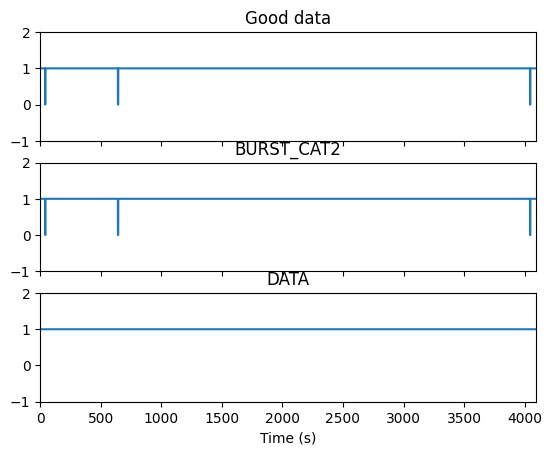

In [5]:
fig, (ax0, ax1, ax2) = plt.subplots(3, sharex=True, sharey=True)
ax0.plot(goodData_mask_1hz)
ax0.set_title('Good data')
ax1.plot(burst_cat2_mask)
ax1.set_title('BURST_CAT2')
ax2.plot(data_mask)
ax2.set_title('DATA')
ax2.axis([0, 4096, -1, 2])
ax2.set_xlabel('Time (s)')

Here are some things to notice in the plot:
  - A 1 means the category is passed, and so that second of data is good to use in your analysis.
  - In this example, `goodData_mask_1hz` is the logical AND of the other two.
  - The `BURST_CAT2` flag is 0 for a short times. So, there are several segments of "good data" in this file.

A convenient way to ignore periods of bad data is to use data quality segments in the form of a list of Python slices. These can be obtained like this:

In [6]:
dummy = np.zeros(goodData_mask_1hz.shape)
masked_dummy = np.ma.masked_array(dummy, np.logical_not(goodData_mask_1hz) )
segments = np.ma.flatnotmasked_contiguous(masked_dummy)
segList = [(int(seg.start+gpsStart), int(seg.stop+gpsStart)) for seg in segments]

We'll see examples of how to use segment lists in the next step.

## What's next?

When you are comfortable with data quality information, you can go to the [next step of this tutorial](<04 - Using the example API.ipynb>).